In [24]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [25]:
# сгенерируем данные

regression_data, regression_y = datasets.make_regression(n_samples=200, n_features=1, n_informative=1, n_targets=1,                                                                          tail_strength=1, noise=10, random_state=8)

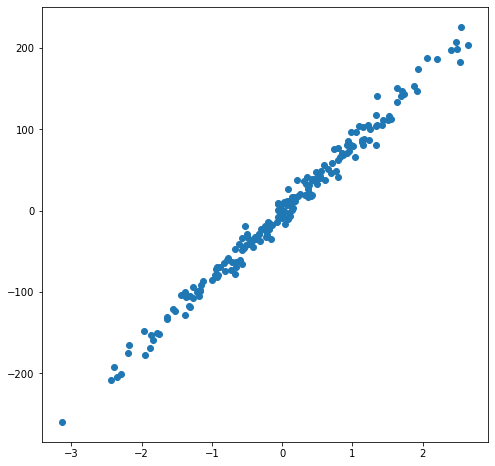

In [26]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(regression_data, regression_y)

In [27]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [28]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, y):
        self.data = data
        self.y = y
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.y)       

In [29]:
# Расчет критерия Джини

def criterion(y):
    #  подсчет количества объектов разных классов
    mean = np.mean(y)
        
    return np.mean((y - mean) ** 2)

In [30]:
# Расчет качества

def quality(left_y, right_y, current_criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_y.shape[0]) / (left_y.shape[0] + right_y.shape[0])
    
    return current_criterion - p * criterion(left_y) - (1 - p) * criterion(right_y)

In [31]:
# Разбиение датасета в узле

def split(data, y, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_y = y[left]
    false_y = y[right]
        
    return true_data, false_data, true_y, false_y

In [32]:
# Нахождение наилучшего разбиения

def find_best_split(data, y, min_leaf=5):
    
    #  обозначим минимальное количество объектов в узле

    current_criterion = criterion(y)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_y, false_y = split(data, y, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_y, false_y, current_criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [33]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, y, min_leaf=5):

    quality, t, index = find_best_split(data, y, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, y)
    

    true_data, false_data, true_y, false_y = split(data, y, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_y, min_leaf)
    false_branch = build_tree(false_data, false_y, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [34]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [35]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [36]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_y, test_y = model_selection.train_test_split(regression_data, 
                                                                                     regression_y, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)


In [37]:
# Построим дерево по обучающей выборке
min_leaf = 15
my_tree = build_tree(train_data, train_y, min_leaf)

In [38]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.06292872986579556
--> True:
  Индекс 0
  Порог -1.1645911721234772
  --> True:
    Прогноз: -142.20623592292998
  --> False:
    Индекс 0
    Порог -0.577799163359741
    --> True:
      Прогноз: -69.64004755459322
    --> False:
      Прогноз: -27.804928732597634
--> False:
  Индекс 0
  Порог 0.9272507137366085
  --> True:
    Индекс 0
    Порог 0.4240514210317228
    --> True:
      Прогноз: 10.854054258750788
    --> False:
      Прогноз: 54.19774486152349
  --> False:
    Индекс 0
    Порог 1.4260580008514914
    --> True:
      Прогноз: 93.49115708393964
    --> False:
      Прогноз: 164.1833065327696


In [39]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [40]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [41]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [42]:
def r2(y_pred, y):
    y_mean = np.mean(y)
    return 1 - np.sum((y - y_pred)**2) / np.sum((y - y_mean)**2)

In [43]:
# Точность на обучающей выборке
train_accuracy = r2(train_answers, train_y)
train_accuracy

0.938963621081643

In [44]:
# Точность на тестовой выборке
test_accuracy = r2(answers, test_y)
test_accuracy

0.9277622094478507

Text(0.5, 1.0, 'train data vs reg prediction min_leaf=15')

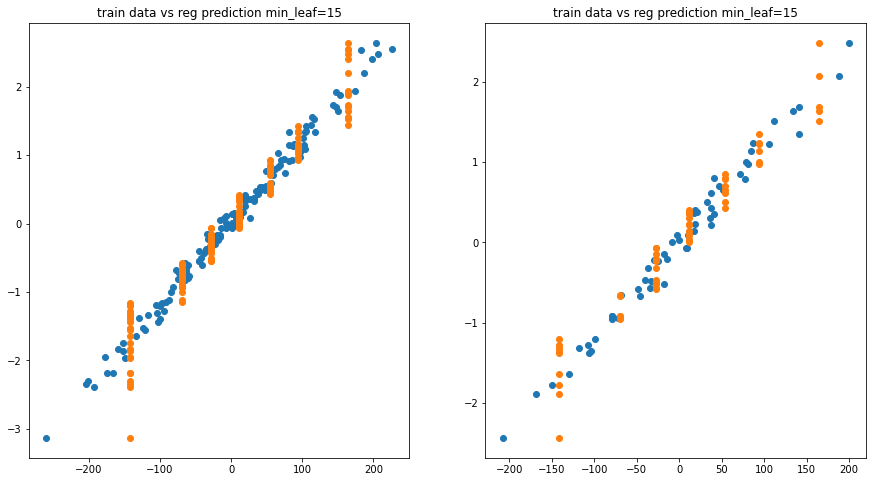

In [45]:
fig = plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.scatter(train_y, train_data )
plt.scatter(train_answers, train_data)
plt.title(f'train data vs reg prediction min_leaf={min_leaf}')

plt.subplot(1,2,2)
plt.scatter(test_y, test_data )
plt.scatter(answers, test_data)
plt.title(f'train data vs reg prediction min_leaf={min_leaf}')

In [46]:
for min_leaf in [2, 3, 5, 10, 20, 40, 80]:
    my_tree = build_tree(train_data, train_y, min_leaf)
    train_answers = predict(train_data, my_tree)
    answers = predict(test_data, my_tree)
    train_accuracy = r2(train_answers, train_y)
    test_accuracy = r2(answers, test_y)
    print(
        f'минимальный размер листа:{min_leaf}\n'
        f'r2 train: {train_accuracy:.2f}\t r2 test: {test_accuracy:.2f}\n')

минимальный размер листа:2
r2 train: 0.99	 r2 test: 0.98

минимальный размер листа:3
r2 train: 0.99	 r2 test: 0.98

минимальный размер листа:5
r2 train: 0.99	 r2 test: 0.98

минимальный размер листа:10
r2 train: 0.97	 r2 test: 0.96

минимальный размер листа:20
r2 train: 0.91	 r2 test: 0.90

минимальный размер листа:40
r2 train: 0.62	 r2 test: 0.59

минимальный размер листа:80
r2 train: 0.00	 r2 test: -0.00

